# News Classification: Comprehensive Solutions Comparison

This notebook implements and compares 7 different approaches to news classification:
- **Baseline**: Embedding + LSTM + Linear
- **Solution 1**: LSTM + Attention Pooling
- **Solution 2**: Transformer (single layer)
- **Solution 3**: Sentence Transformers + LogReg
- **Solution 4**: Distance-based (bi-encoder & cross-encoder)
- **Solution 5**: LLM-based classification
- **Solution 6**: CNN with Conv1d
- **Solution 7**: Word2Vec + LogReg

Each solution is evaluated on:
- Train & Validation Accuracy
- F1-score (macro and weighted)
- Training time
- Inference time

Results are exported to JSON for cross-device comparison.

## Configuration

In [1]:
# DEVICE CONFIGURATION - Change this for different runs
DEVICE = 'cpu'  # Options: 'cpu', 'mps', 'cuda'

# Enable MPS fallback for unsupported operations
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

print(f"Running on device: {DEVICE}")

Running on device: cpu


### Imports and Setup

In [2]:
import random
import json
import time
from pathlib import Path
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import nltk
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# Set random seed for reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if DEVICE == 'mps':
    torch.mps.manual_seed(SEED)
elif DEVICE == 'cuda':
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Random seed set to {SEED}")

Random seed set to 42


In [4]:
# Setup NLTK
TRAIN_PATH = Path.cwd()
nltk.data.path.append(str(TRAIN_PATH / "punkt"))

# Download punkt if not available
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

In [ ]:
nltk.download('punkt_tab')

### Usage Instructions



#### Running on Different Devices

1. **On your current machine (e.g., Mac with MPS)**:
   - Set `DEVICE = 'mps'` at the top of the notebook
   - Run all cells
   - Results will be saved to `results_mps.json`

2. **On a machine with CUDA**:
   - Set `DEVICE = 'cuda'`
   - Run all cells
   - Results will be saved to `results_cuda.json`

3. **On a CPU-only machine**:
   - Set `DEVICE = 'cpu'`
   - Run all cells
   - Results will be saved to `results_cpu.json`

#### Combining Results

After collecting all JSON files:
1. Place all `results_*.json` files in the same directory as this notebook
2. Uncomment the "Cross-Device Comparison" section above
3. Run that cell to see comparison across devices

#### Requirements

Install required packages:
```bash
pip install torch numpy pandas scikit-learn matplotlib seaborn nltk sentence-transformers gensim openai
```

For LLM solution, set your OpenAI API key:
```bash
export OPENAI_API_KEY='your-api-key-here'
```

---

**Happy Experimenting! 🚀**

### Results Tracking

In [5]:
class ResultsTracker:
    """Track metrics for all solutions."""
    def __init__(self, device):
        self.device = device
        self.results = []
    
    def add_result(self, name, metrics):
        """Add results for a solution."""
        result = {"name": name, **metrics}
        self.results.append(result)
        print(f"\n{'='*60}")
        print(f"Results for {name}:")
        print(f"{'='*60}")
        for key, value in metrics.items():
            if isinstance(value, float):
                print(f"{key}: {value:.4f}")
            else:
                print(f"{key}: {value}")
    
    def save_json(self, filename=None):
        """Save results to JSON."""
        if filename is None:
            filename = f"results_{self.device}.json"
        
        output = {
            "device": self.device,
            "solutions": self.results
        }
        
        with open(filename, 'w') as f:
            json.dump(output, f, indent=2)
        
        print(f"\nResults saved to {filename}")
    
    def get_dataframe(self):
        """Return results as DataFrame."""
        return pd.DataFrame(self.results)

# Initialize tracker
tracker = ResultsTracker(DEVICE)

### Helper Functions for Training and Evaluation

In [6]:
@torch.no_grad()
def evaluate_model(model, device, dataloader):
    """Evaluate model accuracy."""
    model.eval()
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        if outputs.dim() > 1 and outputs.size(-1) > 1:
            outputs = outputs.squeeze()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return correct / total

In [7]:
def train_model(model, device, optimizer, criterion, train_loader, val_loader, num_epochs, scheduler=None):
    """Train a PyTorch model and track metrics."""
    train_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            if outputs.dim() > 1 and outputs.size(-1) > 1:
                outputs = outputs.squeeze()
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            # Calculate train accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(train_acc)
        
        # Validation
        val_acc = evaluate_model(model, device, val_loader)
        val_accs.append(val_acc)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        
        # Scheduler step
        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_loss)
            else:
                scheduler.step()
    
    return train_losses, train_accs, val_accs

In [8]:
@torch.no_grad()
def predict_model(model, device, dataloader):
    """Get predictions from model."""
    model.eval()
    all_preds = []
    
    for inputs, _ in dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        if outputs.dim() > 1 and outputs.size(-1) > 1:
            outputs = outputs.squeeze()
        
        _, predicted = torch.max(outputs, 1)
        all_preds.append(predicted.cpu())
    
    return torch.cat(all_preds).numpy()

In [9]:
def compute_metrics(y_true, y_pred, train_time, inference_time, train_acc=None):
    """Compute comprehensive metrics."""
    val_acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    
    metrics = {
        'train_accuracy': train_acc if train_acc is not None else None,
        'val_accuracy': val_acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'train_time_sec': train_time,
        'inference_time_sec': inference_time
    }
    
    return metrics

### Data Loading and Preprocessing

In [ ]:
# ! gdown --fuzzy "https://drive.google.com/file/d/11b9MJwsyZNT01bflOdBGMLYxaabfjndz/view?usp=sharing"
# ! unzip -q news.zip

In [10]:
# Load data
df = pd.read_csv(TRAIN_PATH / "train_news.csv")
print(f"Dataset shape: {df.shape}")
print("\nClass distribution:")
print(df['category'].value_counts())
df.head()

Dataset shape: (1000, 2)

Class distribution:
category
business         290
sport            284
tech             221
entertainment    205
Name: count, dtype: int64


,text,category
0,Campbell rescues Arsenal\n\nSol Campbell prove...,sport
1,Algeria hit by further gas riots\n\nAlgeria su...,business
2,Senior Fannie Mae bosses resign\n\nThe two mos...,business
3,Russia gets investment blessing\n\nSoaring oil...,business
4,Injury sidelines Philippoussis\n\nMark Philipp...,sport


In [11]:
# Train/Val split (80/20)
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=df['category']
)

print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")
print("\nTrain class distribution:")
print(train_df['category'].value_counts())
print("\nVal class distribution:")
print(val_df['category'].value_counts())

Train size: 800
Val size: 200

Train class distribution:
category
business         232
sport            227
tech             177
entertainment    164
Name: count, dtype: int64

Val class distribution:
category
business         58
sport            57
tech             44
entertainment    41
Name: count, dtype: int64


In [12]:
# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df["category"])
y_val = label_encoder.transform(val_df["category"])

print(f"Classes: {label_encoder.classes_}")
print(f"Number of classes: {len(label_encoder.classes_)}")

Classes: ['business' 'entertainment' 'sport' 'tech']
Number of classes: 4


### Text Preprocessing Function

In [13]:
def preprocess(texts, vocab=None, *, max_len=500, vocab_size=25000):
    """Tokenize and encode texts."""
    # Tokenize
    text_tokens = [word_tokenize(text.lower()) for text in texts]

    # Build vocabulary
    vocab_provided = vocab is not None
    if not vocab_provided:
        common_words = Counter([token for text in text_tokens for token in text]).most_common(vocab_size - 2)
        vocab = {word: idx + 2 for idx, (word, _) in enumerate(common_words)}
        vocab["<UNK>"] = 1
        vocab["<PAD>"] = 0

    # Tokens to token IDs
    text_token_ids = []
    for text in text_tokens:
        encoded = [vocab.get(word, vocab["<UNK>"]) for word in text]
        # Truncate if more, pad if less
        encoded += [vocab["<PAD>"]] * (max_len - len(encoded))
        encoded = encoded[:max_len]
        text_token_ids.append(encoded)

    if vocab_provided:
        return text_token_ids
    return text_token_ids, vocab

In [14]:
# Preprocess texts
X_train, vocab = preprocess(train_df["text"].tolist())
X_val = preprocess(val_df["text"].tolist(), vocab=vocab)

print(f"Vocabulary size: {len(vocab)}")
print(f"Max sequence length: {len(X_train[0])}")

Vocabulary size: 21049
Max sequence length: 500


### Dataset and DataLoader

In [15]:
class TextDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.texts[idx], self.labels[idx]
        return self.texts[idx], self.texts[idx]  # Dummy label for compatibility

In [16]:
# Create datasets and dataloaders
BATCH_SIZE = 64

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 13
Val batches: 4


# Solutions

## Baseline: Embedding + LSTM + Linear

In [17]:
class BaselineLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, padding_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        # Use last hidden state
        logits = self.fc(hidden[-1])
        return logits

In [18]:
# Baseline training
print("Training Baseline: Embedding + LSTM + Linear")
print("="*60)

# Model parameters
embedding_dim = 64
hidden_dim = 128
num_epochs = 12

# Initialize model
model_baseline = BaselineLSTM(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_classes=len(label_encoder.classes_),
    padding_idx=vocab["<PAD>"]
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_baseline.parameters(), lr=1e-3)

# Train
start_time = time.time()
train_losses, train_accs, val_accs = train_model(
    model_baseline, DEVICE, optimizer, criterion, 
    train_loader, val_loader, num_epochs
)
train_time = time.time() - start_time

# Inference time
start_time = time.time()
y_pred_baseline = predict_model(model_baseline, DEVICE, val_loader)
inference_time = time.time() - start_time

# Compute metrics
metrics_baseline = compute_metrics(
    y_val, y_pred_baseline, 
    train_time, inference_time,
    train_acc=train_accs[-1]
)

# Save results
tracker.add_result("Baseline (LSTM)", metrics_baseline)

Training Baseline: Embedding + LSTM + Linear
Epoch [1/12], Loss: 1.3792, Train Acc: 0.2975, Val Acc: 0.2800
Epoch [2/12], Loss: 1.3527, Train Acc: 0.3650, Val Acc: 0.2750
Epoch [3/12], Loss: 1.3221, Train Acc: 0.3825, Val Acc: 0.3100
Epoch [4/12], Loss: 1.2919, Train Acc: 0.3787, Val Acc: 0.3350
Epoch [5/12], Loss: 1.2569, Train Acc: 0.3950, Val Acc: 0.3300
Epoch [6/12], Loss: 1.3116, Train Acc: 0.4200, Val Acc: 0.3200
Epoch [7/12], Loss: 1.2286, Train Acc: 0.4412, Val Acc: 0.3150
Epoch [8/12], Loss: 1.1968, Train Acc: 0.4387, Val Acc: 0.3350
Epoch [9/12], Loss: 1.1615, Train Acc: 0.4437, Val Acc: 0.3400
Epoch [10/12], Loss: 1.1266, Train Acc: 0.4713, Val Acc: 0.3300
Epoch [11/12], Loss: 1.0993, Train Acc: 0.4775, Val Acc: 0.3500
Epoch [12/12], Loss: 1.0730, Train Acc: 0.4913, Val Acc: 0.3550

Results for Baseline (LSTM):
train_accuracy: 0.4913
val_accuracy: 0.3550
f1_macro: 0.2568
f1_weighted: 0.2662
train_time_sec: 36.8289
inference_time_sec: 0.2839


## Solution 1: LSTM + Attention Pooling

In [19]:
class AttentionPooling(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attention = nn.Linear(hidden_dim, 1)
    
    def forward(self, lstm_output, mask=None):
        # lstm_output: (batch, seq_len, hidden_dim)
        # Calculate attention scores
        attention_scores = self.attention(lstm_output).squeeze(-1)  # (batch, seq_len)
        
        # Apply mask if provided
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask, -1e9)
        
        # Softmax
        attention_weights = torch.softmax(attention_scores, dim=1)  # (batch, seq_len)
        
        # Weighted sum
        weighted_output = torch.sum(lstm_output * attention_weights.unsqueeze(-1), dim=1)  # (batch, hidden_dim)
        
        return weighted_output


class LSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, padding_idx=0):
        super().__init__()
        self.padding_idx = padding_idx
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = AttentionPooling(hidden_dim * 2)  # *2 for bidirectional
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
    
    def forward(self, x):
        # Create mask for padding
        mask = (x == self.padding_idx)
        
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        
        # Apply attention pooling
        attended = self.attention(lstm_out, mask)
        
        # Classification
        logits = self.fc(attended)
        return logits

In [20]:
# Solution 1 training
print("Training Solution 1: LSTM + Attention Pooling")
print("="*60)

# Model parameters
embedding_dim = 64
hidden_dim = 128
num_epochs = 12

# Initialize model
model_attention = LSTMWithAttention(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_classes=len(label_encoder.classes_),
    padding_idx=vocab["<PAD>"]
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_attention.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Train
start_time = time.time()
train_losses, train_accs, val_accs = train_model(
    model_attention, DEVICE, optimizer, criterion, 
    train_loader, val_loader, num_epochs, scheduler
)
train_time = time.time() - start_time

# Inference time
start_time = time.time()
y_pred_attention = predict_model(model_attention, DEVICE, val_loader)
inference_time = time.time() - start_time

# Compute metrics
metrics_attention = compute_metrics(
    y_val, y_pred_attention, 
    train_time, inference_time,
    train_acc=train_accs[-1]
)

# Save results
tracker.add_result("Solution 1 (LSTM + Attention)", metrics_attention)

Training Solution 1: LSTM + Attention Pooling
Epoch [1/12], Loss: 1.3696, Train Acc: 0.4113, Val Acc: 0.4350
Epoch [2/12], Loss: 1.3176, Train Acc: 0.4788, Val Acc: 0.5200
Epoch [3/12], Loss: 1.0980, Train Acc: 0.4888, Val Acc: 0.5300
Epoch [4/12], Loss: 0.9344, Train Acc: 0.5988, Val Acc: 0.5900
Epoch [5/12], Loss: 0.8705, Train Acc: 0.5913, Val Acc: 0.5250
Epoch [6/12], Loss: 0.8548, Train Acc: 0.6075, Val Acc: 0.7400
Epoch [7/12], Loss: 0.7128, Train Acc: 0.7500, Val Acc: 0.7550
Epoch [8/12], Loss: 0.5863, Train Acc: 0.7538, Val Acc: 0.6550
Epoch [9/12], Loss: 0.5563, Train Acc: 0.8087, Val Acc: 0.8200
Epoch [10/12], Loss: 0.4513, Train Acc: 0.8550, Val Acc: 0.7600
Epoch [11/12], Loss: 0.3697, Train Acc: 0.8788, Val Acc: 0.8750
Epoch [12/12], Loss: 0.2939, Train Acc: 0.9275, Val Acc: 0.7900

Results for Solution 1 (LSTM + Attention):
train_accuracy: 0.9275
val_accuracy: 0.7900
f1_macro: 0.7831
f1_weighted: 0.7902
train_time_sec: 80.0075
inference_time_sec: 0.5552


## Solution 2: Transformer (Single Layer)

In [21]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, dim_feedforward, num_layers, num_classes, padding_idx=0, max_len=500):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.pos_embedding = nn.Embedding(max_len, embedding_dim)
        self.padding_idx = padding_idx

        encoder_layer = nn.TransformerEncoderLayer(embedding_dim, nhead=num_heads, dim_feedforward=dim_feedforward, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.cls_head = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)

        padding_mask = (x == self.padding_idx)
        x = self.token_embedding(x) + self.pos_embedding(positions)

        encoded = self.encoder(x, src_key_padding_mask=padding_mask)
        cls_token = encoded[:, 0, :]

        logits = self.cls_head(cls_token)
        return logits

In [22]:
# Solution 2 training
print("Training Solution 2: Transformer")
print("="*60)

# Model parameters
embedding_dim = 64
num_heads = 4
dim_feedforward = 64
num_layers = 1
num_epochs = 12

# Initialize model
model_transformer = TransformerClassifier(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    dim_feedforward=dim_feedforward,
    num_layers=num_layers,
    num_classes=len(label_encoder.classes_),
    padding_idx=vocab["<PAD>"]
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_transformer.parameters(), lr=1e-3)

# Train
start_time = time.time()
train_losses, train_accs, val_accs = train_model(
    model_transformer, DEVICE, optimizer, criterion, 
    train_loader, val_loader, num_epochs
)
train_time = time.time() - start_time

# Inference time
start_time = time.time()
y_pred_transformer = predict_model(model_transformer, DEVICE, val_loader)
inference_time = time.time() - start_time

# Compute metrics
metrics_transformer = compute_metrics(
    y_val, y_pred_transformer, 
    train_time, inference_time,
    train_acc=train_accs[-1]
)

# Save results
tracker.add_result("Solution 2 (Transformer)", metrics_transformer)

Training Solution 2: Transformer


/Users/voorhs/repos/sirius/sirius-ai/day_3/venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch [1/12], Loss: 1.4304, Train Acc: 0.2537, Val Acc: 0.3600
Epoch [2/12], Loss: 1.3461, Train Acc: 0.3488, Val Acc: 0.4300
Epoch [3/12], Loss: 1.2574, Train Acc: 0.4450, Val Acc: 0.4750
Epoch [4/12], Loss: 1.0737, Train Acc: 0.5825, Val Acc: 0.5150
Epoch [5/12], Loss: 0.9184, Train Acc: 0.6737, Val Acc: 0.5500
Epoch [6/12], Loss: 0.7461, Train Acc: 0.7375, Val Acc: 0.5950
Epoch [7/12], Loss: 0.5462, Train Acc: 0.8400, Val Acc: 0.6350
Epoch [8/12], Loss: 0.3832, Train Acc: 0.8875, Val Acc: 0.6150
Epoch [9/12], Loss: 0.2591, Train Acc: 0.9350, Val Acc: 0.6300
Epoch [10/12], Loss: 0.1772, Train Acc: 0.9688, Val Acc: 0.6400
Epoch [11/12], Loss: 0.1278, Train Acc: 0.9675, Val Acc: 0.6400
Epoch [12/12], Loss: 0.0827, Train Acc: 0.9862, Val Acc: 0.6750

Results for Solution 2 (Transformer):
train_accuracy: 0.9862
val_accuracy: 0.6750
f1_macro: 0.6744
f1_weighted: 0.6767
train_time_sec: 129.3399
inference_time_sec: 0.6705


## Solution 3: Sentence Transformers + Logistic Regression

In [23]:
# Solution 3: Sentence Transformers + LogReg
print("Training Solution 3: Sentence Transformers + LogReg")
print("="*60)

try:
    from sentence_transformers import SentenceTransformer
    
    # Load model
    print("Loading sentence transformer model...")
    sbert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    sbert_model = sbert_model.to(DEVICE)
    
    # Encode texts
    print("Encoding training texts...")
    start_time = time.time()
    train_embeddings = sbert_model.encode(
        train_df['text'].tolist(), 
        batch_size=BATCH_SIZE,
        show_progress_bar=True,
        convert_to_numpy=True
    )
    
    # Train logistic regression
    print("Training Logistic Regression...")
    logreg = LogisticRegression(max_iter=1000, random_state=SEED, n_jobs=-1)
    logreg.fit(train_embeddings, y_train)
    train_time = time.time() - start_time
    
    # Get train accuracy
    train_pred = logreg.predict(train_embeddings)
    train_acc_sbert = accuracy_score(y_train, train_pred)
    
    # Inference
    print("Encoding validation texts...")
    start_time = time.time()
    val_embeddings = sbert_model.encode(
        val_df['text'].tolist(),
        batch_size=BATCH_SIZE,
        show_progress_bar=True,
        convert_to_numpy=True
    )
    y_pred_sbert = logreg.predict(val_embeddings)
    inference_time = time.time() - start_time
    
    # Compute metrics
    metrics_sbert = compute_metrics(
        y_val, y_pred_sbert,
        train_time, inference_time,
        train_acc=train_acc_sbert
    )
    
    # Save results
    tracker.add_result("Solution 3 (SentenceTransformers + LogReg)", metrics_sbert)
    
except ImportError:
    print("ERROR: sentence-transformers not installed. Install with: pip install sentence-transformers")
    print("Skipping Solution 3...")

Training Solution 3: Sentence Transformers + LogReg
Loading sentence transformer model...
Encoding training texts...


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Training Logistic Regression...
Encoding validation texts...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]


Results for Solution 3 (SentenceTransformers + LogReg):
train_accuracy: 0.9875
val_accuracy: 0.9950
f1_macro: 0.9948
f1_weighted: 0.9950
train_time_sec: 22.6734
inference_time_sec: 3.6370


## Solution 4: Distance-based Classification

Bi-encoder (Cosine Similarity)

In [24]:
# Solution 4a: Bi-encoder
print("Training Solution 4a: Bi-encoder (Cosine Similarity)")
print("="*60)

try:
    from sentence_transformers import SentenceTransformer, util
    
    # Load model (reuse if already loaded)
    if 'sbert_model' not in locals():
        print("Loading sentence transformer model...")
        sbert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        sbert_model = sbert_model.to(DEVICE)
    
    # Encode class names
    class_names = label_encoder.classes_.tolist()
    print(f"Class names: {class_names}")
    
    start_time = time.time()
    class_embeddings = sbert_model.encode(class_names)
    
    # Encode validation texts
    print("Encoding validation texts...")
    val_embeddings_bienc = sbert_model.encode(
        val_df['text'].tolist(),
        batch_size=BATCH_SIZE,
        show_progress_bar=True,
    )
    
    # Compute cosine similarities and predict
    similarities = util.cos_sim(val_embeddings_bienc, class_embeddings)
    y_pred_bienc = torch.argmax(similarities, dim=1)
    
    inference_time = time.time() - start_time
    train_time = 0  # No training required
    
    # Get train accuracy (for comparison)
    train_embeddings_bienc = sbert_model.encode(
        train_df['text'].tolist(),
        batch_size=BATCH_SIZE,
        show_progress_bar=True,
    )
    similarities = util.cos_sim(train_embeddings_bienc, class_embeddings)
    y_train_pred_bienc = torch.argmax(similarities, dim=1)
    train_acc_bienc = accuracy_score(y_train, y_train_pred_bienc)
    
    # Compute metrics
    metrics_bienc = compute_metrics(
        y_val, np.array(y_pred_bienc),
        train_time, inference_time,
        train_acc=train_acc_bienc
    )
    
    # Save results
    tracker.add_result("Solution 4a (Bi-encoder)", metrics_bienc)
    
except ImportError:
    print("ERROR: sentence-transformers not installed.")
    print("Skipping Solution 4a...")

Training Solution 4a: Bi-encoder (Cosine Similarity)
Class names: ['business', 'entertainment', 'sport', 'tech']
Encoding validation texts...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]


Results for Solution 4a (Bi-encoder):
train_accuracy: 0.8037
val_accuracy: 0.8050
f1_macro: 0.7860
f1_weighted: 0.7995
train_time_sec: 0
inference_time_sec: 3.6529


/var/folders/01/5fz18bzd0t92p9mkwdt4t_zw0000gn/T/ipykernel_485/4093204056.py:48: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_val, np.array(y_pred_bienc),


## Solution 5: LLM-based Classification

In [25]:
# Solution 5: LLM-based classification

from openai import AsyncOpenAI
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from typing import Literal
import asyncio

# Load openai api key and base url from .env
load_dotenv()

# Define structured output
class NewsClassification(BaseModel):
    reasoning: str = Field(description="Preliminary speculations on the given sample")
    label: Literal["business", "sport", "tech", "entertainment"] = Field(description="Classified category of a given sample")

# Initialize OpenAI client
client = AsyncOpenAI(api_key=os.environ["OPENAI_API_KEY"], base_url=os.environ["OPENAI_BASE_URL"])
val_texts_subset = val_df['text'].tolist()
y_val_subset = y_val

print(f"Testing on {len(y_val_subset)} validation samples...")


async def run_llm_predictions() -> list[int]:
    async def llm_classify(text: str) -> int:
        response = await client.beta.chat.completions.parse(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a news article classifier. Classify the following news article into one of the four categories."},
                {"role": "user", "content": text}
            ],
            response_format=NewsClassification
        )

        result = response.choices[0].message.parsed
        predicted_label = result.label.lower()
        
        return label_encoder.transform([predicted_label])[0]
    
    tasks = [llm_classify(txt) for txt in val_texts_subset]
    return await asyncio.gather(*tasks)

Testing on 200 validation samples...


In [26]:
start_time = time.time()
y_pred_llm = await run_llm_predictions()
inference_time = time.time() - start_time
train_time = 0  # No training required

# Compute metrics on subset
metrics_llm = compute_metrics(
    y_val_subset, np.array(y_pred_llm),
    train_time, inference_time,
    train_acc=None
)

# Save results
tracker.add_result("Solution 5 (LLM OpenAI)", metrics_llm)



Results for Solution 5 (LLM OpenAI):
train_accuracy: None
val_accuracy: 0.9250
f1_macro: 0.9218
f1_weighted: 0.9245
train_time_sec: 0
inference_time_sec: 4.5115


## Solution 6: Convolutional Neural Network (CNN)

In [27]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, kernel_sizes, num_classes, padding_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        
        # Multiple convolutional layers with different kernel sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, kernel_size=k)
            for k in kernel_sizes
        ])
        
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)
    
    def forward(self, x):
        # x: (batch, seq_len)
        embedded = self.embedding(x)  # (batch, seq_len, embedding_dim)
        embedded = embedded.permute(0, 2, 1)  # (batch, embedding_dim, seq_len)
        
        # Apply convolutions and max pooling
        conv_outputs = []
        for conv in self.convs:
            conv_out = torch.relu(conv(embedded))  # (batch, num_filters, seq_len - kernel_size + 1)
            pooled = torch.max_pool1d(conv_out, conv_out.size(2))  # (batch, num_filters, 1)
            conv_outputs.append(pooled.squeeze(2))  # (batch, num_filters)
        
        # Concatenate all conv outputs
        concatenated = torch.cat(conv_outputs, dim=1)  # (batch, num_filters * len(kernel_sizes))
        
        # Dropout and classification
        dropped = self.dropout(concatenated)
        logits = self.fc(dropped)
        
        return logits

In [28]:
# Solution 6 training
print("Training Solution 6: CNN with Conv1d")
print("="*60)

# Model parameters
embedding_dim = 64
num_filters = 100
kernel_sizes = [3, 4, 5]  # Multiple kernel sizes for n-gram patterns
num_epochs = 12

# Initialize model
model_cnn = TextCNN(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    num_filters=num_filters,
    kernel_sizes=kernel_sizes,
    num_classes=len(label_encoder.classes_),
    padding_idx=vocab["<PAD>"]
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)

# Train
start_time = time.time()
train_losses, train_accs, val_accs = train_model(
    model_cnn, DEVICE, optimizer, criterion, 
    train_loader, val_loader, num_epochs
)
train_time = time.time() - start_time

# Inference time
start_time = time.time()
y_pred_cnn = predict_model(model_cnn, DEVICE, val_loader)
inference_time = time.time() - start_time

# Compute metrics
metrics_cnn = compute_metrics(
    y_val, y_pred_cnn, 
    train_time, inference_time,
    train_acc=train_accs[-1]
)

# Save results
tracker.add_result("Solution 6 (CNN)", metrics_cnn)

Training Solution 6: CNN with Conv1d
Epoch [1/12], Loss: 1.7204, Train Acc: 0.2500, Val Acc: 0.4050
Epoch [2/12], Loss: 1.4699, Train Acc: 0.3350, Val Acc: 0.4200
Epoch [3/12], Loss: 1.3210, Train Acc: 0.4138, Val Acc: 0.7600
Epoch [4/12], Loss: 1.1647, Train Acc: 0.5025, Val Acc: 0.7850
Epoch [5/12], Loss: 1.0034, Train Acc: 0.5913, Val Acc: 0.7150
Epoch [6/12], Loss: 0.9134, Train Acc: 0.6562, Val Acc: 0.8150
Epoch [7/12], Loss: 0.8563, Train Acc: 0.6587, Val Acc: 0.8750
Epoch [8/12], Loss: 0.7379, Train Acc: 0.7137, Val Acc: 0.8050
Epoch [9/12], Loss: 0.6453, Train Acc: 0.7675, Val Acc: 0.8850
Epoch [10/12], Loss: 0.6149, Train Acc: 0.7788, Val Acc: 0.9150
Epoch [11/12], Loss: 0.5218, Train Acc: 0.8438, Val Acc: 0.8400
Epoch [12/12], Loss: 0.5184, Train Acc: 0.8187, Val Acc: 0.8950

Results for Solution 6 (CNN):
train_accuracy: 0.8187
val_accuracy: 0.8950
f1_macro: 0.8898
f1_weighted: 0.8939
train_time_sec: 103.1922
inference_time_sec: 1.3708


## Solution 7: Word2Vec + Logistic Regression

In [29]:
# Solution 7: Word2Vec + LogReg
print("Training Solution 7: Word2Vec + Logistic Regression")
print("="*60)

try:
    from gensim.models import Word2Vec
    
    # Tokenize texts
    train_texts_tokenized = [word_tokenize(text.lower()) for text in train_df['text'].tolist()]
    val_texts_tokenized = [word_tokenize(text.lower()) for text in val_df['text'].tolist()]
    
    # Train Word2Vec
    print("Training Word2Vec model...")
    start_time = time.time()
    w2v_model = Word2Vec(
        sentences=train_texts_tokenized,
        vector_size=100,
        window=5,
        min_count=2,
        workers=4,
        seed=SEED
    )
    
    # Function to get document vector (average of word vectors)
    def get_doc_vector(tokens, model):
        vectors = []
        for token in tokens:
            if token in model.wv:
                vectors.append(model.wv[token])
        if len(vectors) == 0:
            return np.zeros(model.vector_size)
        return np.mean(vectors, axis=0)
    
    # Get document vectors
    print("Creating document vectors...")
    train_vectors = np.array([get_doc_vector(tokens, w2v_model) for tokens in train_texts_tokenized])
    val_vectors = np.array([get_doc_vector(tokens, w2v_model) for tokens in val_texts_tokenized])
    
    # Train logistic regression
    print("Training Logistic Regression...")
    logreg_w2v = LogisticRegression(max_iter=1000, random_state=SEED, n_jobs=-1)
    logreg_w2v.fit(train_vectors, y_train)
    
    train_time = time.time() - start_time
    
    # Get train accuracy
    train_pred_w2v = logreg_w2v.predict(train_vectors)
    train_acc_w2v = accuracy_score(y_train, train_pred_w2v)
    
    # Inference
    start_time = time.time()
    y_pred_w2v = logreg_w2v.predict(val_vectors)
    inference_time = time.time() - start_time
    
    # Compute metrics
    metrics_w2v = compute_metrics(
        y_val, y_pred_w2v,
        train_time, inference_time,
        train_acc=train_acc_w2v
    )
    
    # Save results
    tracker.add_result("Solution 7 (Word2Vec + LogReg)", metrics_w2v)
    
except ImportError:
    print("ERROR: gensim not installed. Install with: pip install gensim")
    print("Skipping Solution 7...")

Training Solution 7: Word2Vec + Logistic Regression
Training Word2Vec model...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Creating document vectors...
Training Logistic Regression...

Results for Solution 7 (Word2Vec + LogReg):
train_accuracy: 0.7262
val_accuracy: 0.7200
f1_macro: 0.6857
f1_weighted: 0.7015
train_time_sec: 4.2685
inference_time_sec: 0.0015


# Results Comparison and Visualization

## Summary Table

In [30]:
# Display results table
results_df = tracker.get_dataframe()

# Sort by validation accuracy
results_df_sorted = results_df.sort_values('val_accuracy', ascending=False)

print("\\n" + "="*80)
print("SUMMARY OF ALL SOLUTIONS")
print("="*80)
print(results_df_sorted.to_string(index=False))
print("="*80)

\n================================================================================
SUMMARY OF ALL SOLUTIONS
                                      name  train_accuracy  val_accuracy  f1_macro  f1_weighted  train_time_sec  inference_time_sec
Solution 3 (SentenceTransformers + LogReg)         0.98750         0.995  0.994777     0.994991       22.673438            3.636987
                   Solution 5 (LLM OpenAI)             NaN         0.925  0.921754     0.924518        0.000000            4.511513
                          Solution 6 (CNN)         0.81875         0.895  0.889788     0.893913      103.192185            1.370826
                  Solution 4a (Bi-encoder)         0.80375         0.805  0.785969     0.799543        0.000000            3.652882
             Solution 1 (LSTM + Attention)         0.92750         0.790  0.783093     0.790155       80.007478            0.555154
            Solution 7 (Word2Vec + LogReg)         0.72625         0.720  0.685682     0.701477     

## Visualizations

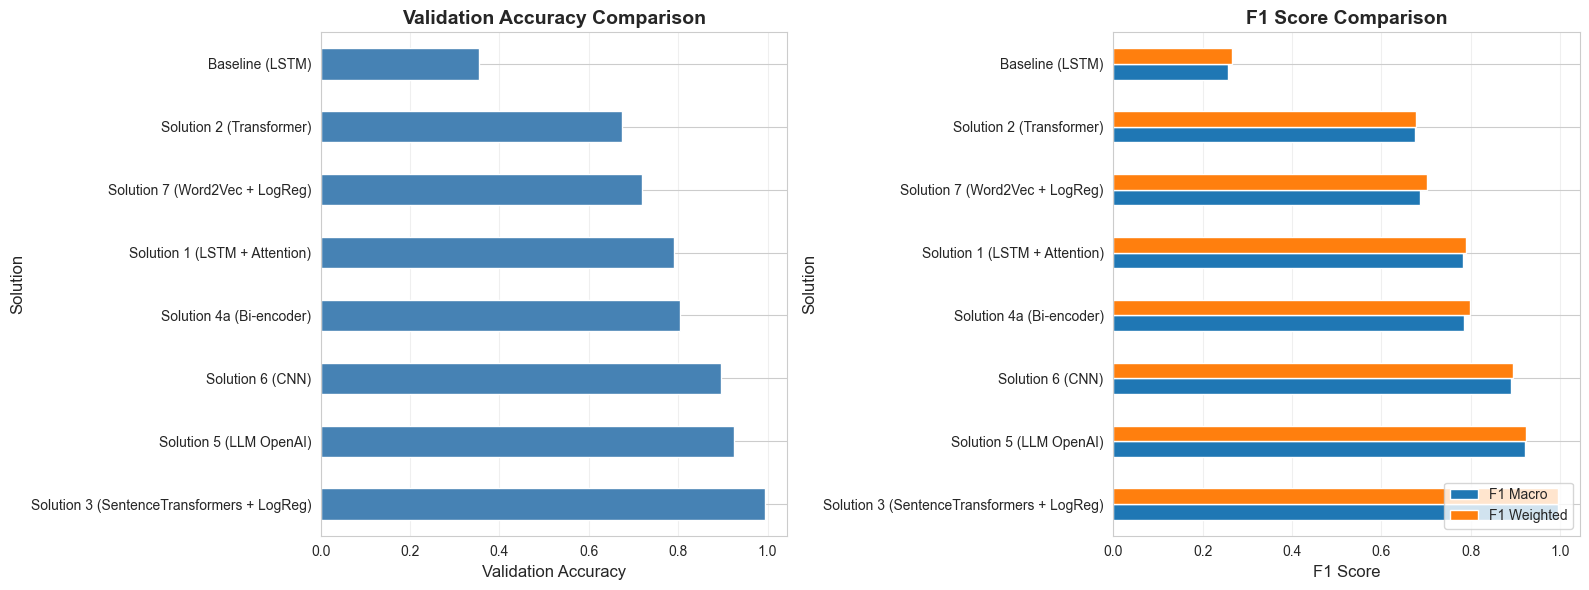

In [31]:
# 1. Accuracy Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Validation Accuracy
ax1 = axes[0]
results_df_sorted.plot(
    x='name', 
    y='val_accuracy', 
    kind='barh', 
    ax=ax1, 
    legend=False,
    color='steelblue'
)
ax1.set_xlabel('Validation Accuracy', fontsize=12)
ax1.set_ylabel('Solution', fontsize=12)
ax1.set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# F1 Scores
ax2 = axes[1]
f1_data = results_df_sorted[['name', 'f1_macro', 'f1_weighted']].set_index('name')
f1_data.plot(kind='barh', ax=ax2)
ax2.set_xlabel('F1 Score', fontsize=12)
ax2.set_ylabel('Solution', fontsize=12)
ax2.set_title('F1 Score Comparison', fontsize=14, fontweight='bold')
ax2.legend(['F1 Macro', 'F1 Weighted'], loc='lower right')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'accuracy_comparison_{DEVICE}.png', dpi=300, bbox_inches='tight')
plt.show()

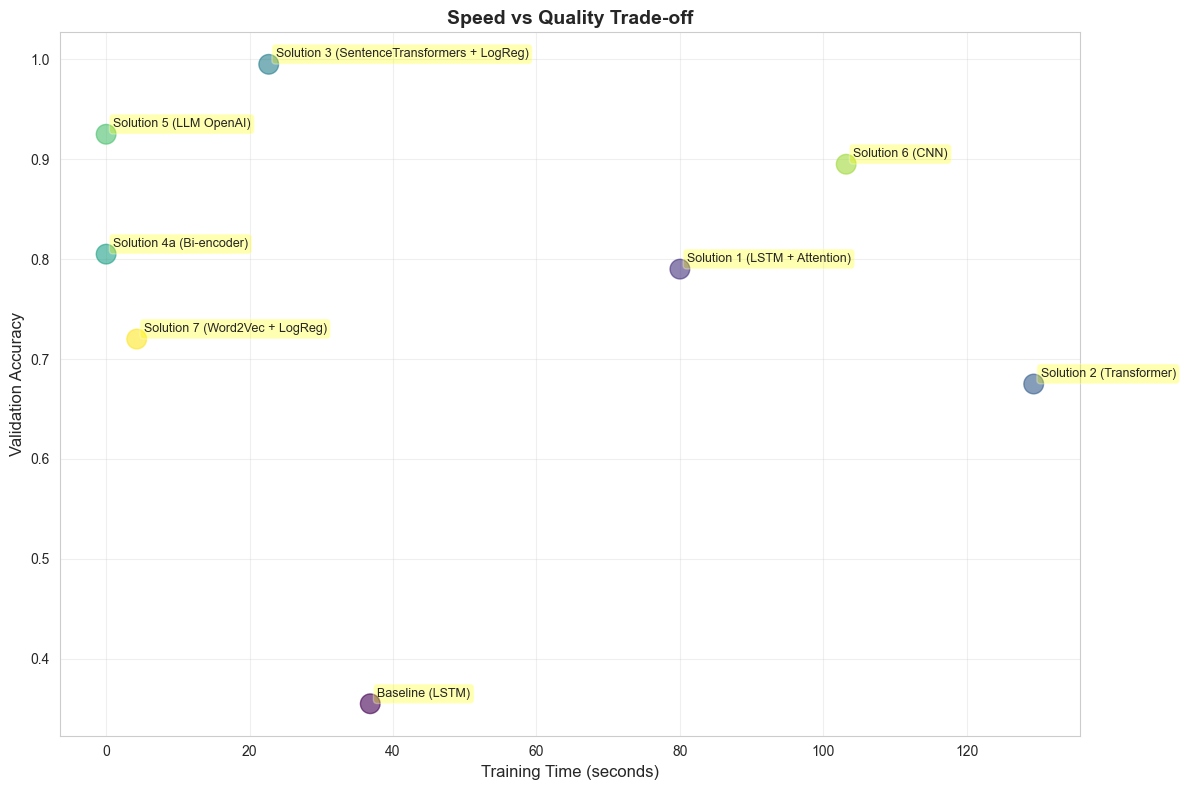

In [32]:
# 2. Speed vs Quality
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    results_df['train_time_sec'], 
    results_df['val_accuracy'],
    s=200,
    alpha=0.6,
    c=range(len(results_df)),
    cmap='viridis'
)

# Add labels for each point
for idx, row in results_df.iterrows():
    ax.annotate(
        row['name'], 
        (row['train_time_sec'], row['val_accuracy']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3)
    )

ax.set_xlabel('Training Time (seconds)', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.set_title('Speed vs Quality Trade-off', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'speed_vs_quality_{DEVICE}.png', dpi=300, bbox_inches='tight')
plt.show()

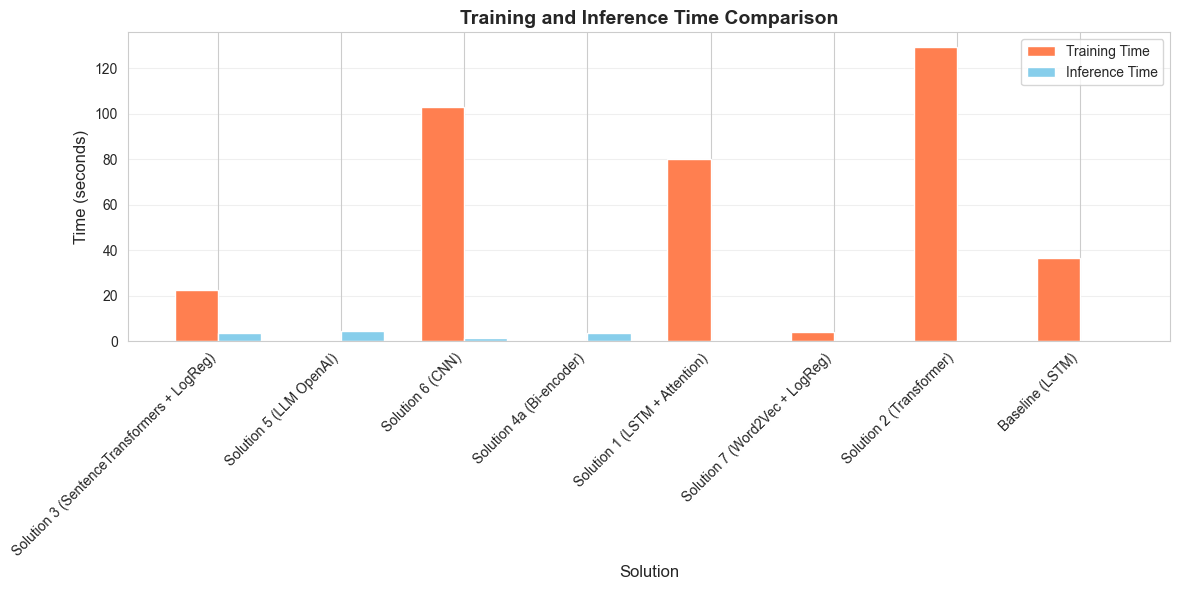

In [33]:
# 3. Training and Inference Time Comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(results_df_sorted))
width = 0.35

bars1 = ax.bar(x - width/2, results_df_sorted['train_time_sec'], width, label='Training Time', color='coral')
bars2 = ax.bar(x + width/2, results_df_sorted['inference_time_sec'], width, label='Inference Time', color='skyblue')

ax.set_xlabel('Solution', fontsize=12)
ax.set_ylabel('Time (seconds)', fontsize=12)
ax.set_title('Training and Inference Time Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df_sorted['name'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'time_comparison_{DEVICE}.png', dpi=300, bbox_inches='tight')
plt.show()

## Export Results to JSON

In [34]:
# Save results to JSON for cross-device comparison
tracker.save_json()

print(f"\\nResults have been saved to results_{DEVICE}.json")
print("Copy this file to combine results from different devices.")


Results saved to results_cpu.json
\nResults have been saved to results_cpu.json
Copy this file to combine results from different devices.


## Cross-Device Comparison (Run after collecting all results)

\n====================================================================================================
CROSS-DEVICE COMPARISON
                                      name  device  val_accuracy  train_time_sec  inference_time_sec
                           Baseline (LSTM) cpu_mac         0.355       36.828902            0.283949
             Solution 1 (LSTM + Attention) cpu_mac         0.790       80.007478            0.555154
                  Solution 2 (Transformer) cpu_mac         0.675      129.339911            0.670492
Solution 3 (SentenceTransformers + LogReg) cpu_mac         0.995       22.673438            3.636987
                  Solution 4a (Bi-encoder) cpu_mac         0.805        0.000000            3.652882
                   Solution 5 (LLM OpenAI) cpu_mac         0.925        0.000000            4.511513
                          Solution 6 (CNN) cpu_mac         0.895      103.192185            1.370826
            Solution 7 (Word2Vec + LogReg) cpu_mac         0.720 

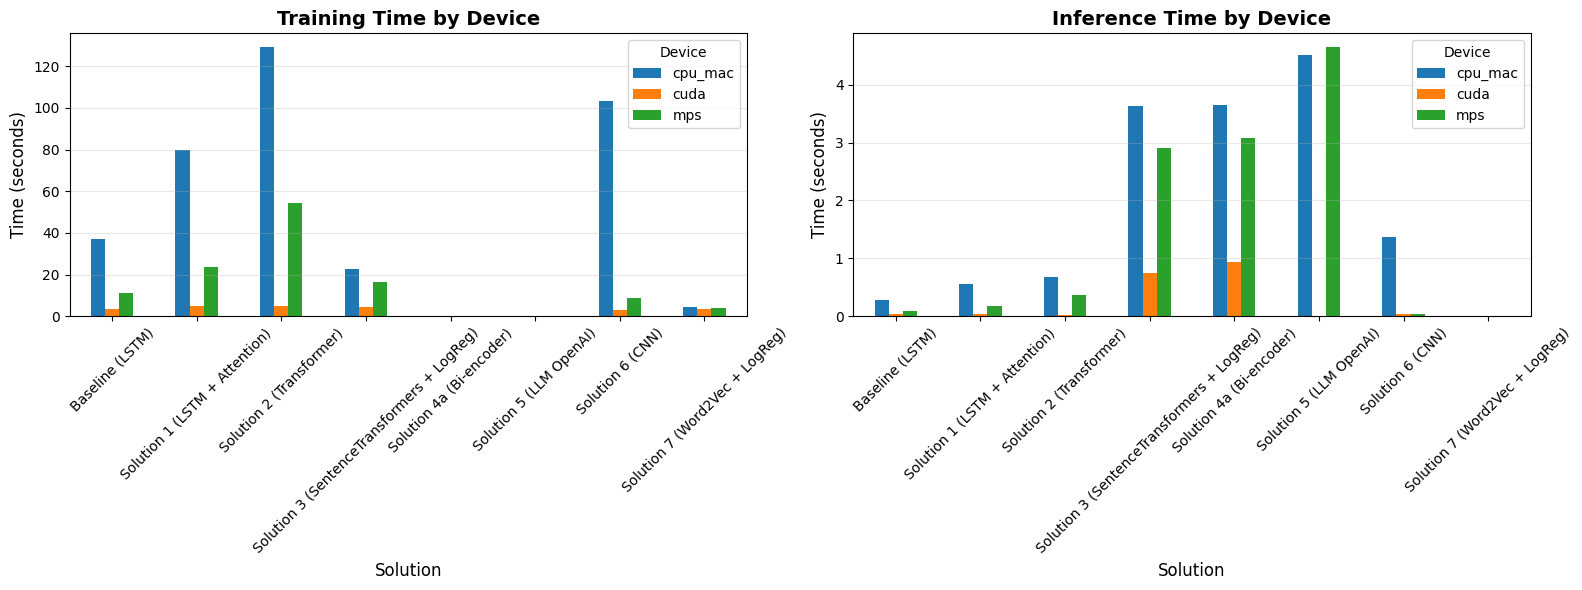

In [2]:
# Uncomment and run this section after collecting results from all devices
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load results from all devices
devices_to_compare = ['cpu_mac', 'mps', 'cuda']
all_results = []

for device_name in devices_to_compare:
    try:
        with open(f'results_{device_name}.json', 'r') as f:
            data = json.load(f)
            for solution in data['solutions']:
                solution['device'] = device_name
                all_results.append(solution)
    except FileNotFoundError:
        print(f"Warning: results_{device_name}.json not found, skipping...")

if all_results:
    # Create DataFrame
    all_results_df = pd.DataFrame(all_results)
    
    # Display table
    print("\\n" + "="*100)
    print("CROSS-DEVICE COMPARISON")
    print("="*100)
    print(all_results_df[['name', 'device', 'val_accuracy', 'train_time_sec', 'inference_time_sec']].to_string(index=False))
    print("="*100)
    
    # Visualize device comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Training time comparison
    pivot_train = all_results_df.pivot(index='name', columns='device', values='train_time_sec')
    pivot_train.plot(kind='bar', ax=axes[0])
    axes[0].set_title('Training Time by Device', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Solution', fontsize=12)
    axes[0].set_ylabel('Time (seconds)', fontsize=12)
    axes[0].legend(title='Device')
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Inference time comparison
    pivot_infer = all_results_df.pivot(index='name', columns='device', values='inference_time_sec')
    pivot_infer.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Inference Time by Device', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Solution', fontsize=12)
    axes[1].set_ylabel('Time (seconds)', fontsize=12)
    axes[1].legend(title='Device')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('device_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No results files found for comparison.")

# Conclusions and Recommendations

## Summary

This notebook compared 7 different approaches to news classification, evaluating them on:
- **Accuracy**: How well they classify news articles
- **Training Speed**: How long it takes to train the model
- **Inference Speed**: How fast they can classify new articles

## Expected Results and Trade-offs

### Deep Learning Solutions (Baseline, LSTM+Attention, Transformer, CNN)
- **Pros**: Can achieve high accuracy with proper training
- **Cons**: Require significant training time, especially on CPU
- **Best for**: Scenarios where accuracy is paramount and you have GPU resources

### Pre-trained Embeddings (SentenceTransformers + LogReg)
- **Pros**: No training required for embeddings, fast inference, good accuracy
- **Cons**: Requires downloading pre-trained models
- **Best for**: Quick deployment, when you need good results without training

### Distance-based (Bi-encoder)
- **Pros**: Zero-shot capability (no training), interpretable
- **Best for**: 
  - **Bi-encoder**: Quick prototyping and cold-start scenarios

### LLM-based (OpenAI API)
- **Pros**: State-of-the-art accuracy, no local computation
- **Cons**: API costs, variable inference speed, requires internet connection
- **Best for**: High-stakes scenarios where accuracy justifies the cost

### Classical ML (Word2Vec + LogReg)
- **Pros**: Fast training, interpretable, no GPU needed
- **Cons**: May not capture complex patterns as well as deep learning
- **Best for**: Baseline comparison, resource-constrained environments

## Recommendations by Use Case

1. **Production with GPU**: LSTM + Attention or Transformer
   - Balance of accuracy and speed

2. **Maximum Accuracy**: SentenceTransformers + LogReg
   - Fast inference, good accuracy, no training needed

3. **Quick Prototype**: LLM-based
   - Zero-shot, fast, no training, no-deployment

5. **Resource Constrained**: Word2Vec + LogReg
   - Works on any hardware, fast training

## Key Insights

- Pre-trained models (SentenceTransformers) often outperform custom-trained models on small datasets
- Zero-shot approaches (distance-based) can provide surprisingly good results without any training
- Deep learning models benefit significantly from GPU acceleration
- The best solution depends heavily on your specific constraints (time, resources, accuracy requirements)